In [545]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [546]:
df = pd.read_csv('netflix_dataset.csv')

In [547]:
netflix_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [548]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Clean Data

In [550]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [551]:
# Fill null values in specific columns... NaN -> Unknown
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df['date_added'] = df['date_added'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Unknown')
df['duration'] = df['duration'].fillna('Unknown')

## Exploratory Data Analysis

Text(0, 0.5, 'Cantidad')

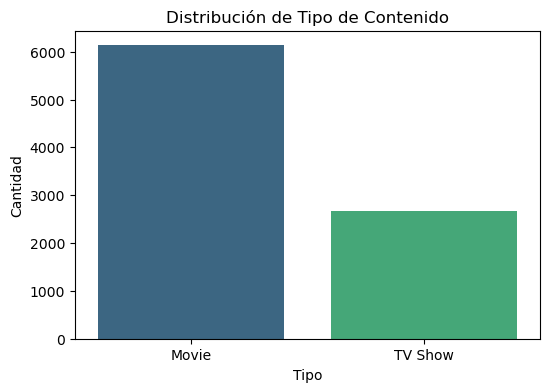

In [553]:
plt.figure(figsize=(6,4))
sns.countplot(x='type', hue='type', data=df, palette='viridis', legend=False)
plt.title('Distribución de Tipo de Contenido')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')

Text(0, 0.5, 'Cantidad de Estrenos')

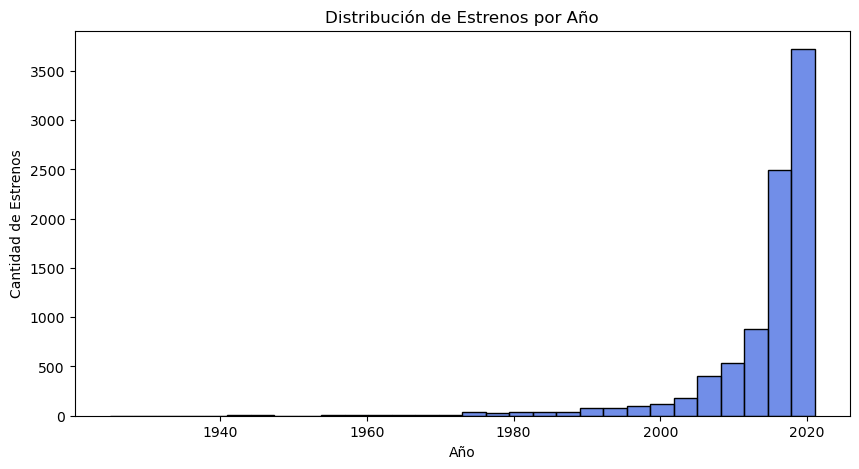

In [554]:
plt.figure(figsize=(10,5))
sns.histplot(df['release_year'], bins=30, color='royalblue')
plt.title('Distribución de Estrenos por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Estrenos')

Text(0, 0.5, 'País')

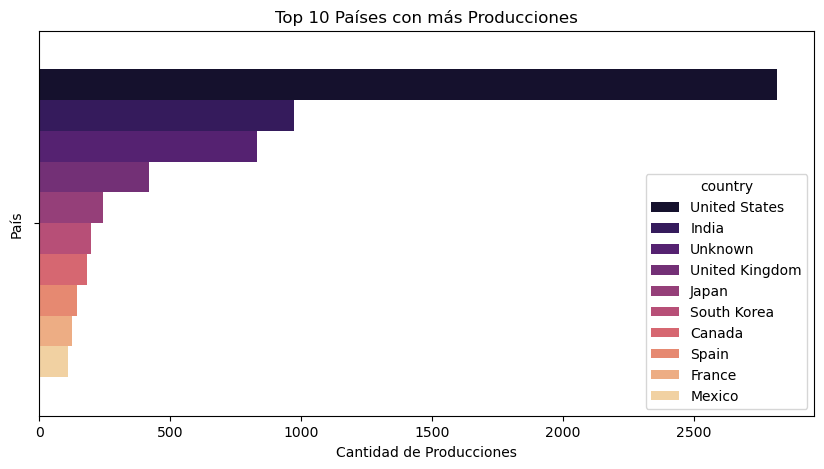

In [555]:
top_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values, hue=top_countries.index, palette='magma')
plt.title('Top 10 Países con más Producciones')
plt.xlabel('Cantidad de Producciones')
plt.ylabel('País')

### Convert genders to a numerical representation

In [557]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Use TfidfVectorizer to convert genders into vectors
tfidf = TfidfVectorizer(stop_words='english')

# Create the matrix of gender characteristics
tfidf_matrix = tfidf.fit_transform(df['listed_in'])

# Check the form of the matrix (how many documents and how many terms)
print(tfidf_matrix.shape)


(8807, 44)


In [558]:
### Calculate the similarity between genders

In [559]:
# Calculate the cosine similarity matrix between the movies/series.
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Check the result (the similarity matrix)
print(cosine_sim.shape)


(8807, 8807)


### Create a function to get recommendations

In [658]:
# Ponderación de Features

stop_words_custom = ['movie', 'film', 'series', 'show', 'netflix', 'season']
# Combinar features con pesos estratégicos y NLP mejorado
df['boosted_genres'] = df['listed_in'].apply(
    lambda x: ' '.join([genre.strip() for genre in x.split(',') * 3])  # Géneros x3 peso
)

df['enhanced_description'] = df['description'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words_custom])
)

df['combined_features'] = df['boosted_genres'] + ' ' + df['enhanced_description']

In [660]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Configuración para capturar frases clave y evitar ruido
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),  # Bigramas para capturar "time travel"
    max_features=5000,    # Enfocar en las palabras más discriminativas
    min_df=2             # Ignorar palabras raras
)
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

In [662]:
from sklearn.metrics.pairwise import linear_kernel

# Usamos linear_kernel (más eficiente que cosine_similarity para TF-IDF)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [664]:
def improved_recommendations(title, df=df, cosine_sim=cosine_sim, top_n=5):
    # Encontrar índice y géneros del título
    idx = df.index[df['title'].str.lower() == title.lower()].tolist()
    if not idx:
        return "Título no encontrado"
    idx = idx[0]
    target_genres = set(df.iloc[idx]['listed_in'].split(', '))
    
    # Obtener similitudes y filtrar por género principal
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Filtrado en dos pasos:
    recommendations = []
    seen_titles = {title.lower()}
    
    for i, score in sim_scores[1:top_n*3]:  # Buscar en un pool más grande
        current_genres = set(df.iloc[i]['listed_in'].split(', '))
        # Condición 1: Comparte al menos 1 género principal
        # Condición 2: No es el mismo título
        if (current_genres & target_genres) and (df.iloc[i]['title'].lower() not in seen_titles):
            recommendations.append((i, score))
            seen_titles.add(df.iloc[i]['title'].lower())
        if len(recommendations) >= top_n:
            break
    
    # Devolver resultados con metadatos útiles
    return df.iloc[[i[0] for i in recommendations]][['title', 'listed_in', 'description']]

In [668]:
# Ejemplo: Eliminar películas para niños si el título original es para adultos
df['rating'] = df['rating'].fillna('Unknown')
def filter_by_rating(recommendations, target_rating):
    return recommendations[
        recommendations['rating'].apply(lambda x: x in target_rating)
    ]

In [670]:
print(recommend_by_genre_and_plot("Dark"))

                 title
2979      THE STRANGER
869   Who Killed Sara?
5350            Fartsa
5716          Paranoid
5057       Retribution
